#### **Problem 0**
Access the CSMAR database and download the following data for all listed firms in the A-share market.

Ⅰ Monthly Stock Closing Price, Return (without cash dividend reinvested) over Dec. 2009 to Dec. 2024 from Individual Stock Trading table;

Ⅱ Quarterly Return on Equity - TTM and Net Assets per Share over 2009Q3 to 2024Q4 from Financial Indicator table;

Ⅲ Daily stock volatility (of the log return of the lastest 250 trading days) at 2010/12/31 from Stock Market Derivative Index table.

Then derive monthly P/B ratios for all A-share stocks from Jan. 2010 to Dec. 2024. Exclude records with P/B ratios less than P/B ratio’s 5th percentile or greater than P/B ratio’s 95th percentile.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

monthly = pd.read_csv("data/monthly/TRD_Mnth.csv")
quarterly_roe = pd.read_csv("data/quarterly/ROE_ttm/FI_T5.csv") 
quarterly_naps = pd.read_csv("data/quarterly/NAPS/FI_T9.csv")
daily = pd.read_csv("data/daily/STK_MKT_STKBTAL.csv")

In [11]:
"""Derive monthly P/B ratios"""

# Data Manipulation.
monthly.columns = ["code", "time", "price", "return"]
monthly["time"] = pd.to_datetime(monthly["time"]).dt.to_period("M")

quarterly_naps = quarterly_naps[quarterly_naps["Typrep"] != "B"]
quarterly_naps = quarterly_naps.drop(columns = ["ShortName_EN", "Typrep"])
quarterly_naps.columns = ["code", "time", "naps"]
quarterly_naps["time"] = (pd.to_datetime(quarterly_naps["time"])+ pd.DateOffset(months=1)).dt.to_period("M")

# Merge two dfs.
merged_df = pd.merge(monthly, quarterly_naps, how = "left", on = ["code", "time"])
merged_df["naps"] = merged_df.groupby("code")["naps"].ffill()
merged_df = merged_df.dropna(subset = ["naps"])

# Calculate and manipulate P/B.
merged_df["pb_ratio"] = merged_df["price"] / merged_df["naps"]
pb_5th, pb_95th = merged_df["pb_ratio"].quantile(0.05), merged_df["pb_ratio"].quantile(0.95)
merged_df = merged_df[(merged_df["pb_ratio"] > pb_5th) & (merged_df["pb_ratio"] < pb_95th) ]
print(merged_df)

          code     time  price    return      naps  pb_ratio
1            1  2010-01  21.70 -0.109561  6.591545  3.292096
2            1  2010-02  22.45  0.034562  6.591545  3.405878
3            1  2010-03  23.20  0.033408  6.591545  3.519660
4            1  2010-04  20.56 -0.113793  7.119722  2.887753
5            1  2010-05  17.51 -0.148346  7.119722  2.459366
...        ...      ...    ...       ...       ...       ...
606577  873833  2024-08   7.54 -0.074847  7.498464  1.005539
606578  873833  2024-09   9.86  0.307692  7.498464  1.314936
606579  873833  2024-10  12.94  0.327586  7.337831  1.763464
606580  873833  2024-11  17.31  0.337713  7.337831  2.359008
606581  873833  2024-12  11.40 -0.341421  7.337831  1.553593

[540843 rows x 6 columns]


#### **Problem 1**
a. Focuse on the observations for all A-share firms at the end of 2010, regress the P/B ratio at Dec. 2010 on Return on Equity - TTM (ROE) at 2010Q4 and Stock Volatility at 2010/12/31, i.e., estimate the following cross-sectional regression:
$$
P/B_i = \alpha + \beta_1 ROE_i + \beta_2 \text{Stock Volatility}_i + \epsilon_i.
$$

In [12]:
# Data Manipulation.
quarterly_roe = quarterly_roe[quarterly_roe["Typrep"] != "B"]
quarterly_roe = quarterly_roe.drop(columns = ["ShortName_EN", "Typrep"])
quarterly_roe.columns = ["code", "time", "roe"]
quarterly_roe = quarterly_roe.dropna(subset = ["roe"])
quarterly_roe["time"] = pd.to_datetime(quarterly_roe["time"]).dt.to_period("Q")

daily = daily.drop(columns = "TradingDate")
daily.columns = ["code", "volatility"]

roe_p1 = (quarterly_roe[quarterly_roe["time"] == "2010Q4"]).drop(columns = "time")
pb_p1 = (merged_df[merged_df["time"] == "2010-12"]).drop(columns = ["time", "price", "return", "naps"])

# Merge 3 dfs.
df_p1 = pd.merge(pb_p1, roe_p1, how = "left", on = "code")
df_p1 = pd.merge(df_p1, daily, how = "left", on = "code")
df_p1 = df_p1.dropna(subset = ["pb_ratio", "roe", "volatility"])

# Do the regression.
X = df_p1[["roe", "volatility"]]
X = sm.add_constant(X)
y = df_p1["pb_ratio"]

model = sm.OLS(y, X) 
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               pb_ratio   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     104.9
Date:                Fri, 14 Mar 2025   Prob (F-statistic):           4.14e-43
Time:                        20:12:10   Log-Likelihood:                -2808.0
No. Observations:                1374   AIC:                             5622.
Df Residuals:                    1371   BIC:                             5638.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2057      0.279      0.738      0.4

#### **Problem 2**
b. For each month from Jan. 2010 to Dec. 2024, sort firms based on their last-month P/B ratios and divide firms into ten groups according to last-month P/B ratio deciles. By holding all stocks within each group with equal weights and rebalancing positions every month, we can construct ten portfolios. Calculate the monthly returns for the ten portfolios and use a bar chart to illustrate average returns for the ten portfolios from Jan. 2010 to Dec. 2024, and discuss your findings.

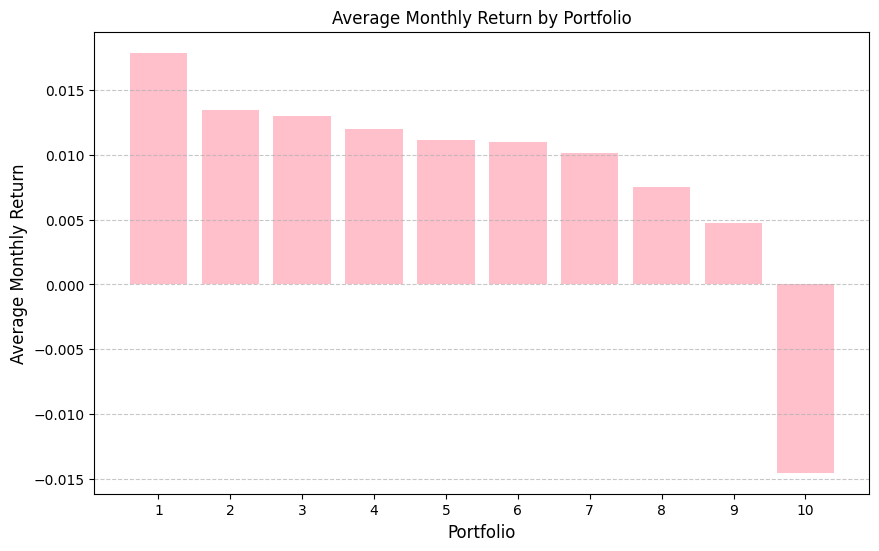

In [13]:
merged_df = merged_df.sort_values(by = ["code", "time"])
merged_df["lagged_pb"] = merged_df.groupby("code")["pb_ratio"].shift(1)
merged_df = merged_df.dropna(subset = "lagged_pb")

portfolio_return = pd.DataFrame()

for month, month_data in merged_df.groupby("time"):
    month_data["portfolio"] = pd.qcut(month_data["lagged_pb"], q = 10, labels = False) + 1
    portfolio_avg_return = month_data.groupby("portfolio")["return"].mean().reset_index()
    portfolio_avg_return["time"] = month
    portfolio_return = pd.concat([portfolio_return, portfolio_avg_return])

_portfolio_return = portfolio_return.groupby("portfolio")["return"].mean().reset_index()

# Plot the figure.
plt.figure(figsize = (10, 6))
plt.bar(_portfolio_return["portfolio"], _portfolio_return["return"], color = "pink")
plt.xlabel("Portfolio", fontsize = 12)
plt.ylabel("Average Monthly Return", fontsize = 12)
plt.title("Average Monthly Return by Portfolio")
plt.xticks(range(1, 11))
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show()